# Advanced Lane Line Finding Project Workbook

## Libraries and Includes

In [17]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

## Camera Calibration

In [18]:
# Update the number of x points to 9 as indicated in the lesson
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
numberOfUndetected = 0
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), flags=(cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE + cv2.CALIB_CB_FAST_CHECK))

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'camera_cal/corners_found_'+ fname.split('\\')[-1]
        #print(write_name)
        cv2.imwrite(write_name, img)
    else:
        numberOfUndetected = numberOfUndetected + 1

print(numberOfUndetected)

3


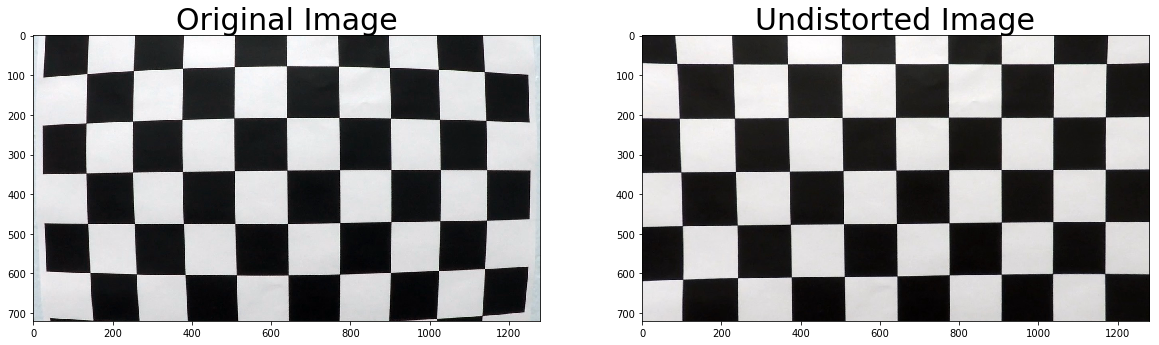

In [19]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/dist_pickle.p", "wb" ) )
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Apply Distortion Correction to Test Images

In [20]:
# Load pickled data
calibration_data = "camera_cal/dist_pickle.p"

with open(calibration_data, mode='rb') as f:
    dist_pickle = pickle.load(f)
    
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [21]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

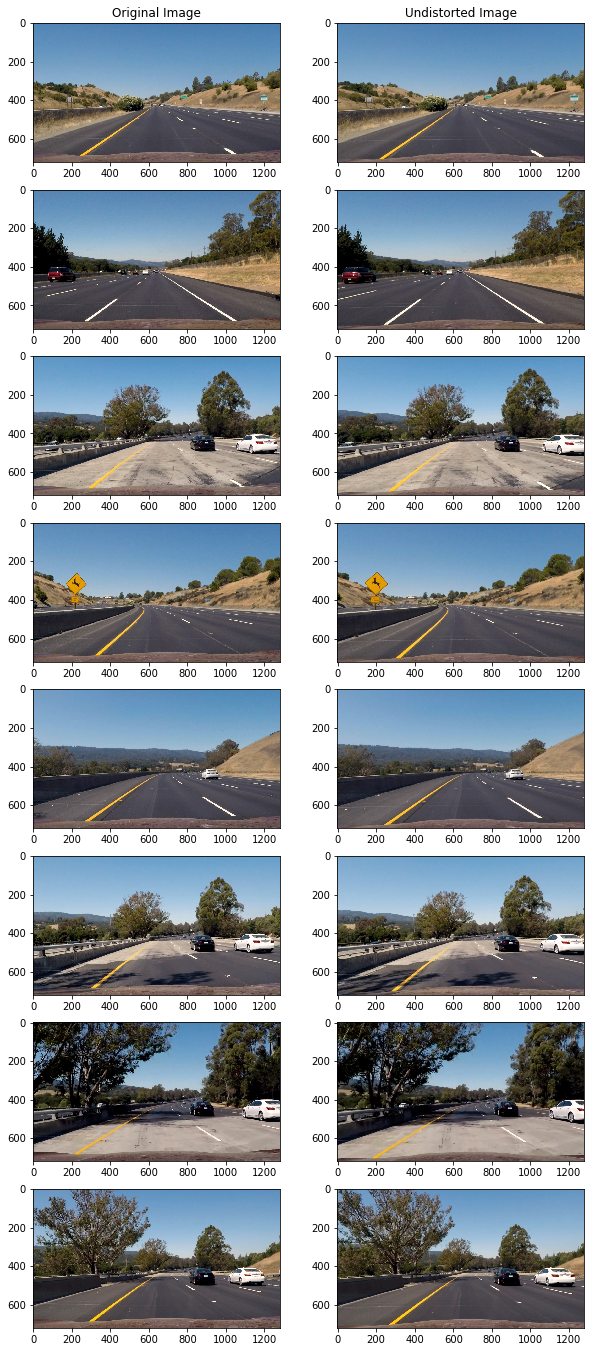

In [22]:
images_name = glob.glob('test_images/*')

plt.figure(figsize=(10, 24))

images = []
for idx, fname in enumerate(images_name):
    img = cv2.imread(fname)
    plt.subplot(len(images_name), 2, idx*2+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if (idx == 0):
        plt.title("Original Image")
    
    img = undistort(img)
    plt.subplot(len(images_name), 2, idx*2+2)
    images.append(img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if (idx == 0):
        plt.title("Undistorted Image")

## Create Thresholded Binary Test Images

In [23]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

In [24]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [25]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

### Crop Images in Y-axis

In [26]:
# Original Image size
image_shape = images[0].shape
print(image_shape)

(720, 1280, 3)


Looking at the images above, we can safely crop more than half of the images to focuse on only the road

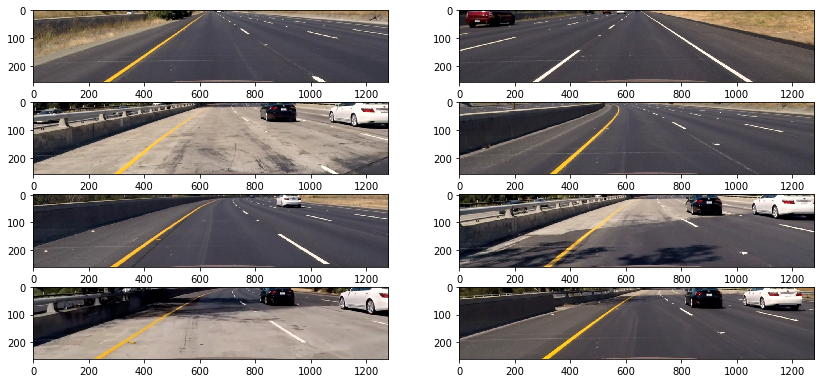

In [30]:
plt.figure(figsize=(14, 6.5))

cropped_images = []
for idx, image in enumerate(images):
    cropped_image = image[420:680,:,:]
    cropped_images.append(cropped_image)
    plt.subplot(len(images)/2, 2, idx+1)
    plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

### Visualise in BGR Space

Blue channel does not pick up yellow lines, wheras green and red do. Only perform thresholding on these two channels.

Red channels consistantly picks up the lane lines better than the other two channels.

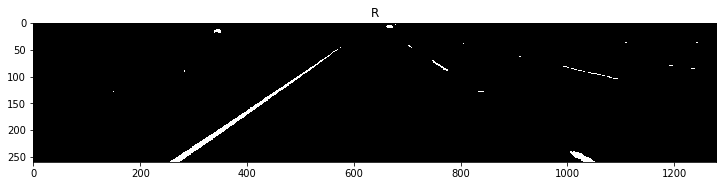

In [84]:
#plt.figure(figsize=(14, 9.5))
plt.figure(figsize=(14, 24))

G_threshold = (200, 255)
R_threshold = (225, 255)

for idx, image in enumerate(cropped_images):
    B = image[:,:,0]
    G = image[:,:,1]
    R = image[:,:,2]
    
    #plt.subplot(len(cropped_images), 3, idx*3+1)
    #plt.imshow(B, cmap='gray')
    #if (idx == 0):
    #    plt.title("B")
        
    #plt.subplot(len(cropped_images), 3, idx*3+2)
    #G_binary = np.zeros_like(G)
    #G_binary[(G > G_threshold[0]) & (G <= G_threshold[1])] = 1
    #plt.imshow(G_binary, cmap='gray')
    #if (idx == 0):
    #    plt.title("G")
        
    #plt.subplot(len(cropped_images), 3, idx*3+3)
    plt.subplot(len(cropped_images), 1, idx+1)
    R_binary = np.zeros_like(G)
    R_binary[(R > R_threshold[0]) & (R <= R_threshold[1])] = 1
    plt.imshow(R_binary, cmap='gray')
    if (idx == 0):
        plt.title("R")
        
    # breaking early to reduce page size
    break

### Visualise in HLS Space

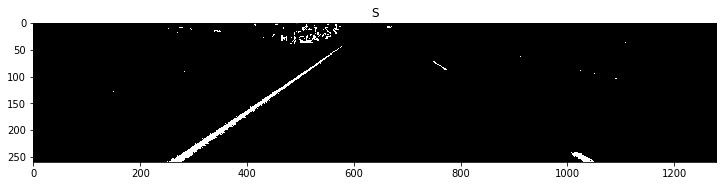

In [83]:
#plt.figure(figsize=(14, 9.5))
plt.figure(figsize=(14, 24))

H_threshold = (15, 100)
S_threshold = (150, 255)

for idx, image in enumerate(cropped_images):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    #plt.subplot(len(cropped_images), 3, idx*3+1)
    #H_binary = np.zeros_like(G)
    #H_binary[(H > H_threshold[0]) & (H <= H_threshold[1])] = 1
    #plt.imshow(H_binary, cmap='gray')
    #if (idx == 0):
    #    plt.title("H")
    
    #plt.subplot(len(cropped_images), 3, idx*3+2)
    #plt.imshow(L, cmap='gray')
    #if (idx == 0):
    #    plt.title("L")
    
    #plt.subplot(len(cropped_images), 3, idx*3+3)
    plt.subplot(len(cropped_images), 1, idx+1)
    S_binary = np.zeros_like(G)
    S_binary[(S > S_threshold[0]) & (S <= S_threshold[1])] = 1
    plt.imshow(S_binary, cmap='gray')
    if (idx == 0):
        plt.title("S")
    
    # breaking early to reduce page size
    break

Red channel seems to be giving better result compare to S colour space

### Visualise in LUV Space

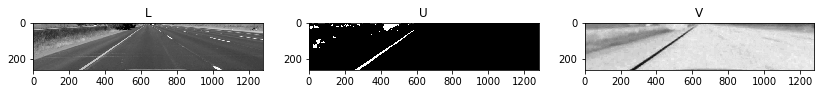

In [82]:
plt.figure(figsize=(14, 9.5))

U_threshold = (100, 120)

for idx, image in enumerate(cropped_images):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    L = hls[:,:,0]
    U = hls[:,:,1]
    V = hls[:,:,2]
    
    plt.subplot(len(cropped_images), 3, idx*3+1)
    plt.imshow(L, cmap='gray')
    if (idx == 0):
        plt.title("L")
    
    plt.subplot(len(cropped_images), 3, idx*3+2)
    U_binary = np.zeros_like(U)
    U_binary[(U > U_threshold[0]) & (U <= U_threshold[1])] = 1
    plt.imshow(U_binary, cmap='gray')
    if (idx == 0):
        plt.title("U")
    
    plt.subplot(len(cropped_images), 3, idx*3+3)
    plt.imshow(V, cmap='gray')
    if (idx == 0):
        plt.title("V")
    
    # breaking early to reduce page size
    break

The U colour space is suprisingly good at picking out yellow lane lines. Therefore I will combine the results of the red channel and U channel to enhance the yellow lane detection.

## Apply a perspective transform to rectify binary image

Using the two straight lane images to develop the perspective transform